In [1]:
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification, pipeline
import shap
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import lime
from lime.lime_text import LimeTextExplainer

## SHAP calculations

In [36]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# add special tokens for URLs, emojis and mentions (--> see pre-processing)
special_tokens_dict = {'additional_special_tokens': ['[USER]','[EMOJI]','[URL]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [37]:
with open("Data/HateCheck_test_suite_cases.txt", "r") as ff: 
    hatecheck_cases = ff.read().splitlines()
    
targets = ['women', 'Muslims']

In [ ]:
datasets = ['Founta_abuse', 'Founta_hate', 'Davidson_abuse', 'Davidson_hate', 'CAD_abuse', 'CAD_hate']

shap_scores = {}
shap_tokens = {}

for dataset in datasets:
    print("Processing {}".format(dataset))
    model = BertForSequenceClassification.from_pretrained("Models/Classifiers/{}".format(dataset))
    model.resize_token_embeddings(len(tokenizer))
    model.eval()
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    explainer = shap.Explainer(classifier)
  #  preds = classifier(hatecheck_cases)
  #  pos_cases = [tt for tt, pp in zip(hatecheck_cases, preds) if pp['label'] == 'LABEL_1']
    shap_values = explainer(hatecheck_cases)
    shap_tokens[dataset] = [[ww.strip().lower() for ww in list(dd)] for dd in shap_values.data]
    shap_scores[dataset] = shap_values.values.tolist()



In [42]:
scores = {dd:[] for dd in datasets}
targets = {dd:[] for dd in datasets}

for dataset in datasets:
    for tt, ss in zip(shap_tokens[dataset], shap_scores[dataset]):
        if 'women' in tt:
            scores[dataset].append(ss[tt.index('women'), 1])
            targets[dataset].append('women')
        elif 'woman' in tt:
            scores[dataset].append(ss[tt.index('woman'), 1])
            targets[dataset].append('women')
        elif 'female' in tt:
            scores[dataset].append(ss[tt.index('female'), 1])
            targets[dataset].append('women')
        elif 'muslims' in tt:
            scores[dataset].append(ss[tt.index('muslims'), 1])
            targets[dataset].append('Muslims')
        elif 'muslim' in tt:
            scores[dataset].append(ss[tt.index('muslim'), 1])
            targets[dataset].append('Muslims')
        else:
            raise ValueError("Didn't find either target in {}".format(tt))

In [43]:
df_dict = {('shap', dd): scores[dd] for dd in datasets}
ind = [(tt, xx.strip()) for xx, tt in zip(hatecheck_cases, targets['Founta_hate'])]
shap_df = pd.DataFrame(df_dict, index=ind)
shap_df.columns = pd.MultiIndex.from_tuples(shap_df.columns, names=['value','Dataset'])
shap_df.index = pd.MultiIndex.from_tuples(shap_df.index, names=['target', 'text'])
shap_df

value                                                              shap  \
Dataset                                                    Founta_abuse   
target  text                                                              
women   I hate women.                                         -0.081214   
Muslims I hate Muslims.                                        0.194154   
women   I really can't stand women like you.                   0.306760   
Muslims I really can't stand Muslims like you.                 0.889467   
women   I despise women.                                       0.293056   
...                                                                 ...   
Muslims You and all other Muslims are a plague to society.     0.192951   
women   Women are subhuman creatures.                         -0.426457   
Muslims Muslims are subhuman creatures.                        0.085760   
women   Swarms of women are infesting our government.         -0.036018   
Muslims Swarms of Muslims are infesting our government.        0.353865   

value                                                                   \
Dataset                                                    Founta_hate   
target  text                                                             
women   I hate women.                                         0.262211   
Muslims I hate Muslims.                                       0.510954   
women   I really can't stand women like you.                  0.113460   
Muslims I really can't stand Muslims like you.                0.984090   
women   I despise women.                                      0.975598   
...                                                                ...   
Muslims You and all other Muslims are a plague to society.    0.502755   
women   Women are subhuman creatures.                         0.000000   
Muslims Muslims are subhuman creatures.                       0.985472   
women   Swarms of women are infesting our government.         0.363990   
Muslims Swarms of Muslims are infesting our government.       0.989458   

value                                                                      \
Dataset                                                    Davidson_abuse   
target  text                                                                
women   I hate women.                                            0.243309   
Muslims I hate Muslims.                                         -0.059254   
women   I really can't stand women like you.                     0.447396   
Muslims I really can't stand Muslims like you.                   0.247127   
women   I despise women.                                         0.033458   
...                                                                   ...   
Muslims You and all other Muslims are a plague to society.       0.032091   
women   Women are subhuman creatures.                            0.036910   
Muslims Muslims are subhuman creatures.                          0.017210   
women   Swarms of women are infesting our government.            0.322510   
Muslims Swarms of Muslims are infesting our government.          0.228077   

value                                                                     \
Dataset                                                    Davidson_hate   
target  text                                                               
women   I hate women.                                          -0.405851   
Muslims I hate Muslims.                                         0.586353   
women   I really can't stand women like you.                    0.000000   
Muslims I really can't stand Muslims like you.                  0.990018   
women   I despise women.                                        0.000000   
...                                                                  ...   
Muslims You and all other Muslims are a plague to society.      0.773205   
women   Women are subhuman creatures.                          -0.316438 

In [44]:
pickle.dump(shap_df, open("Data/shap_scores.pickle", "wb"))

In [266]:
master_df = pickle.load(open("Data/HateCheck_individual_necc_suff_scores.pickle", "rb"))
joint_df = pd.merge(master_df, shap_df, left_index=True, right_index=True)
joint_df = joint_df[joint_df["prediction"] == 1]

In [268]:
joint_df['shap'].groupby(level='target').mean().transpose()

target,Muslims,women
Dataset,,
Founta_abuse,0.386570,-0.072048
Founta_hate,0.837800,0.362759
Davidson_abuse,0.371201,0.416992
Davidson_hate,0.885726,0.012300
CAD_abuse,0.745639,0.658568
CAD_hate,0.951458,0.893915


## LIME calculations

In [10]:
dataset = "Founta_abuse"
model = BertForSequenceClassification.from_pretrained("Models/Classifiers/{}".format(dataset))
model.resize_token_embeddings(len(tokenizer))
model.eval()
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

def get_probas(classifier_output):
    probas = [dd['score'] for dd in classifier_output]
    probas = [[1-pp, pp] for pp in probas]
    return np.array(probas)

In [ ]:
datasets = ['Founta_abuse', 'Founta_hate', 'Davidson_abuse', 'Davidson_hate', 'CAD_abuse', 'CAD_hate']

lime_explanations = {}

def get_probas(classifier_output):
    probas = [dd['score'] for dd in classifier_output]
    probas = [[1-pp, pp] for pp in probas]
    return np.array(probas)

for dataset in datasets:
    print("Processing {}".format(dataset))
    model = BertForSequenceClassification.from_pretrained("Models/Classifiers/{}".format(dataset))
    model.resize_token_embeddings(len(tokenizer))
    model.eval()
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    predictor = lambda x: get_probas(classifier(x))
    explainer = LimeTextExplainer(class_names=['0','1'])
    lime_explanations[dataset] = [explainer.explain_instance(ii, predictor).as_list() for ii in hatecheck_cases]

In [30]:
df_dict = {('lime', dd): scores[dd] for dd in datasets}
ind = [(tt, xx.strip()) for xx, tt in zip(hatecheck_cases, targets['Founta_hate'])]
lime_df = pd.DataFrame(df_dict, index=ind)
lime_df.columns = pd.MultiIndex.from_tuples(lime_df.columns, names=['value','Dataset'])
lime_df.index = pd.MultiIndex.from_tuples(lime_df.index, names=['target', 'text'])
pickle.dump(lime_df, open("Data/lime_scores.pickle", "wb"))

In [2]:
lime_df = pickle.load(open("Data/lime_scores.pickle", "rb"))
shap_df = pickle.load(open("Data/shap_scores.pickle", "rb"))
master_df = pickle.load(open("Data/HateCheck_individual_necc_suff_scores.pickle", "rb"))
joint_df = pd.merge(master_df, shap_df, left_index=True, right_index=True)
joint_df = pd.merge(joint_df, lime_df, left_index=True, right_index=True)
joint_df = joint_df[joint_df["prediction"] == 1]

In [3]:
joint_df['lime'].groupby(level='target').mean().transpose()

target,Muslims,women
Dataset,,
Founta_abuse,0.042473,0.010842
Founta_hate,0.013246,0.017777
Davidson_abuse,-0.032338,0.000660
Davidson_hate,-0.001794,-0.021387
CAD_abuse,0.087413,0.045351
CAD_hate,0.042053,0.012245


In [5]:
joint_df['shap'].groupby(level='target').std().transpose()

target,Muslims,women
Dataset,,
Founta_abuse,0.245637,0.207969
Founta_hate,0.201438,0.243449
Davidson_abuse,0.204407,0.190994
Davidson_hate,0.153063,0.015975
CAD_abuse,0.215145,0.234213
CAD_hate,0.112638,0.171596


In [7]:
joint_df['lime'].groupby(level='target').std().transpose()

target,Muslims,women
Dataset,,
Founta_abuse,0.037029,0.019701
Founta_hate,0.036125,0.045193
Davidson_abuse,0.092032,0.086088
Davidson_hate,0.057279,0.018439
CAD_abuse,0.062244,0.087658
CAD_hate,0.048781,0.076756


## Correlations

In [279]:
corrs = {dd: joint_df.xs(dd, level='Dataset', axis=1)[['necessity', 'sufficiency', 'shap']].corr() for dd in datasets}
df_concat = pd.concat([cc for cc in corrs.values()])
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_means

value,necessity,sufficiency,shap
value,,,
necessity,1.000000,-0.060096,0.533178
shap,0.533178,0.475336,1.000000
sufficiency,-0.060096,1.000000,0.475336


In [47]:
corrs = {dd: joint_df.xs(dd, level='Dataset', axis=1)[['necessity', 'sufficiency', 'lime']].corr() for dd in datasets}
df_concat = pd.concat([cc for cc in corrs.values()])
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_means

value,necessity,sufficiency,lime
value,,,
lime,-0.174395,0.400866,1.000000
necessity,1.000000,-0.060096,-0.174395
sufficiency,-0.060096,1.000000,0.400866


In [287]:
joint_df[('length', '')] = [len(tt.split()) for tt in joint_df.index.get_level_values("text").to_list()]
plot_df = pd.DataFrame()
plot_df['length'] = joint_df[('length', '')]
plot_df['shap'] = joint_df[('shap', 'Founta_hate')]
plot_df['necessity'] = joint_df[('necessity', 'Founta_hate')]
plot_df['sufficiency'] = joint_df[('sufficiency', 'Founta_hate')]

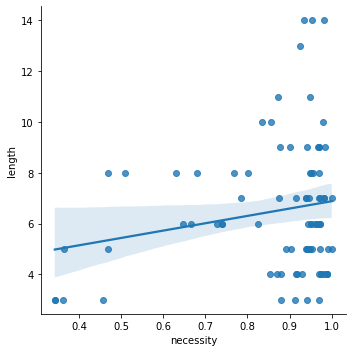

In [288]:
g = sns.lmplot(x="necessity", y="length", data=plot_df)

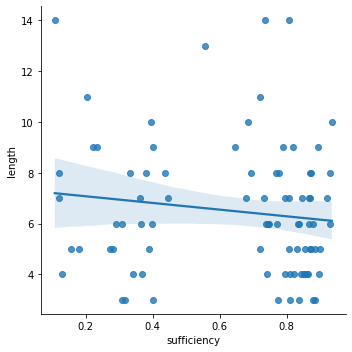

In [289]:
g = sns.lmplot(x="sufficiency", y="length", data=plot_df)

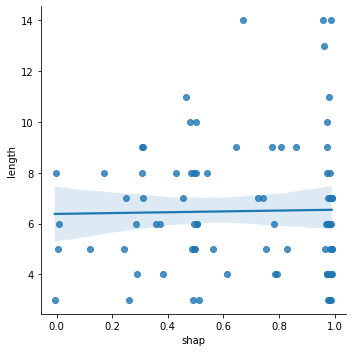

In [290]:
g = sns.lmplot(x="shap", y="length", data=plot_df)

In [187]:
founta_hate_df = joint_df.xs('Founta_hate', level='Dataset', axis=1)
founta_hate_df[['necessity', 'sufficiency', 'shap']].corr()

value,necessity,sufficiency,shap
value,,,
necessity,1.000000,0.031458,0.553243
sufficiency,0.031458,1.000000,0.607583
shap,0.553243,0.607583,1.000000


In [129]:
founta_hate_df.loc['Muslims'][['necessity', 'sufficiency', 'shap']].corr()

value,necessity,sufficiency,shap
value,,,
necessity,1.000000,-0.364118,0.713625
sufficiency,-0.364118,1.000000,-0.462875
shap,0.713625,-0.462875,1.000000


In [130]:
founta_hate_df.loc['women'][['necessity', 'sufficiency', 'shap']].corr()

value,necessity,sufficiency,shap
value,,,
necessity,1.000000,-0.579832,0.460458
sufficiency,-0.579832,1.000000,-0.142093
shap,0.460458,-0.142093,1.000000


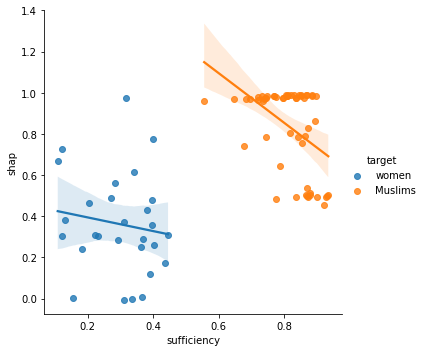

In [223]:
# This is Simpson's paradox! Lets plot to make sure this is what we are seeing. 
plot_df = founta_hate_df.copy()
plot_df.index = founta_hate_df.index.get_level_values('text')
plot_df['target'] = founta_hate_df.index.get_level_values('target')
g = sns.lmplot(x="sufficiency", y="shap", hue="target", data=plot_df)

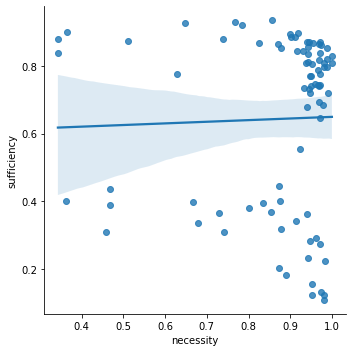

In [122]:
g = sns.lmplot(x="necessity", y="sufficiency", data=plot_df)

In [98]:
founta_hate_df[['necessity_mask', 'sufficiency_mask', 'shap']].corr()

value,necessity_mask,sufficiency_mask,shap
value,,,
necessity_mask,1.000000,0.332593,0.832790
sufficiency_mask,0.332593,1.000000,0.719289
shap,0.832790,0.719289,1.000000


In [111]:
founta_hate_df[['necessity', 'necessity_mask']].corr()

value,necessity,necessity_mask
value,,
necessity,1.000000,0.715417
necessity_mask,0.715417,1.000000


In [105]:
founta_hate_df[['sufficiency', 'sufficiency_mask']].corr()

value,sufficiency,sufficiency_mask
value,,
sufficiency,1.000000,0.849035
sufficiency_mask,0.849035,1.000000


In [147]:
from tqdm import tqdm
from perturbation_functions import get_preds_and_scores, calc_suff, calc_necc

# re-calculate the necc and suff scores for Founta-hate as comparison
perts = pickle.load(open("Data/HateCheck_necc_suff_perturbations_2.pickle","rb"))
perts['orig_texts'] = [tt.strip(' \n') for tt in perts['orig_texts']]
dataset = "Founta_hate"

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# add special tokens for URLs, emojis and mentions (--> see pre-processing)
special_tokens_dict = {'additional_special_tokens': ['[USER]','[EMOJI]','[URL]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

print("Classifying HateCheck perturbations with {}.".format(dataset))
#  model = BertForSequenceClassification.from_pretrained(models_dir +'BERT_{}_weighted/Final'.format(dataset))
model = BertForSequenceClassification.from_pretrained("Models/Classifiers/{}".format(dataset))
model.resize_token_embeddings(len(tokenizer))
model.eval()

total_len = len(perts['orig_texts']) + sum(len(nn) for nn in perts['necc_perturbed']) + sum(len(nn) for nn in perts['suff_perturbed'])

with tqdm(total=total_len) as pbar:
    orig_preds, orig_scores = get_preds_and_scores(perts['orig_texts'], tokenizer, model, pbar)

    necc_preds = []
    necc_scores = []

    for tt in perts['necc_perturbed']:
        pp, ss = get_preds_and_scores(tt, tokenizer, model, pbar)
        necc_preds.append(pp)
        necc_scores.append(ss)

    suff_preds = []
    suff_scores = []

    for tt in perts['suff_perturbed']:
        pp, ss = get_preds_and_scores(tt, tokenizer, model, pbar)
        suff_preds.append(pp)
        suff_scores.append(ss)


Founta_hate_2_results = {
            'orig_preds': orig_preds,
            'orig_scores': orig_scores,
            'necc_preds': necc_preds,
            'necc_scores': necc_scores,
            'suff_preds': suff_preds,
            'suff_scores': suff_scores,
            }

Classifying HateCheck perturbations with Founta_hate.


100%|████████████████████████| 66240/66240 [53:50<00:00, 20.51it/s]


In [200]:
necc_results_2 = []
suff_results_2 = []
baseline_preds = pickle.load(open("Data/Classifier_baselines.pickle", "rb"))
baseline_pred = baseline_preds['baseline_preds']['Founta_hate']

## NECCESSITY CALCULATIONS
for oo, pp, mm in zip(Founta_hate_2_results['orig_preds'], 
                      Founta_hate_2_results['necc_preds'], 
                      perts['necc_masks']):
    if oo == 1:
        pp = np.array(pp)
        necc_results_2.append(calc_necc(oo, pp, mm))

## SUFFICIENCY CALCULATIONS

suffs = []
for oo, pp, mm in zip(Founta_hate_2_results['orig_preds'],
                      Founta_hate_2_results['suff_preds'], 
                      perts['suff_masks']):
    if oo == 1:
        pp = np.array(pp)
        suff_results_2.append(calc_suff(baseline_pred, pp, mm))



In [ ]:
hc_data = pd.read_csv(open("hatecheck-data/test_suite_cases.csv"))
hc_data.test_case = hc_data.test_case.apply(lambda tt: tt.strip())

In [ ]:
hc_templs = hc_data[['case_templ']]
hc_index = hc_data[['test_case', 'target_ident']].rename(mapper={'test_case':'text', 'target_ident':'target'}, axis='columns')
hc_templs.index = pd.MultiIndex.from_frame(hc_index)

In [189]:
founta_hate_df = founta_hate_df.merge(hc_templs, how='left', left_index=True, right_index=True)

In [203]:
def find_placeholder(text):
    text = text.strip().split()
    for nn, tt in enumerate(text):
        if tt[:1] == '[':
            return nn
        
placeholder_locs = [find_placeholder(tt) for tt in founta_hate_df.case_templ.tolist()]
founta_hate_df['necessity_2'] = [ll[nn] for ll, nn in zip(necc_results_2, placeholder_locs)]
founta_hate_df['sufficiency_2'] = [ll[nn] for ll, nn in zip(suff_results_2, placeholder_locs)]

In [205]:
founta_hate_df[['necessity', 'necessity_2']].corr()

,necessity,necessity_2
necessity,1.000000,0.967537
necessity_2,0.967537,1.000000


In [206]:
founta_hate_df[['sufficiency', 'sufficiency_2']].corr()

,sufficiency,sufficiency_2
sufficiency,1.000000,0.975396
sufficiency_2,0.975396,1.000000


In [211]:
founta_hate_df['suff_diff'] = (founta_hate_df['sufficiency'] - founta_hate_df['sufficiency_2']).abs()
founta_hate_df['necc_diff'] = (founta_hate_df['necessity'] - founta_hate_df['necessity_2']).abs()

In [216]:
founta_hate_df['suff_diff'].mean()

0.04708747129972614

In [217]:
founta_hate_df['necc_diff'].mean()

0.03210738294093411